In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv('twitter_training.csv')

In [43]:
df.sample(7)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
62035,5035,GrandTheftAuto(GTA),Positive,When GTA 6 comes out im sure buys it right awa...
14170,2829,Dota2,Positive,was one of d<unk> moments HAHAHHHAHA
62322,5083,GrandTheftAuto(GTA),Negative,Holy shit
71446,11037,TomClancysGhostRecon,Negative,Those who decided about the direction of @Ghos...
50852,6328,FIFA,Negative,The bulk majority our artists struggle
69700,3942,Cyberpunk2077,Neutral,Really wondering when @CDPROJEKTRED is gonna g...
23723,4466,Google,Neutral,don’t google ur symptoms guys just found out i...


In [44]:
df.describe()

,2401
count,74681.000000
mean,6432.640149
std,3740.423819
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [45]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [46]:
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


In [47]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [48]:
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode' 
                   , "im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)

In [49]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

In [50]:
lands =df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


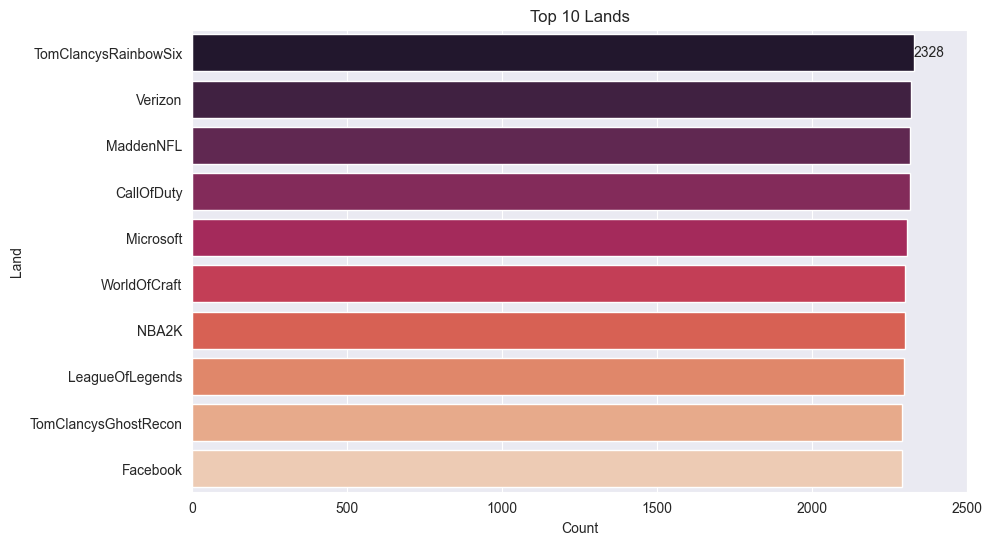

In [51]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

In [52]:
mode = df.Mode.value_counts()
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537


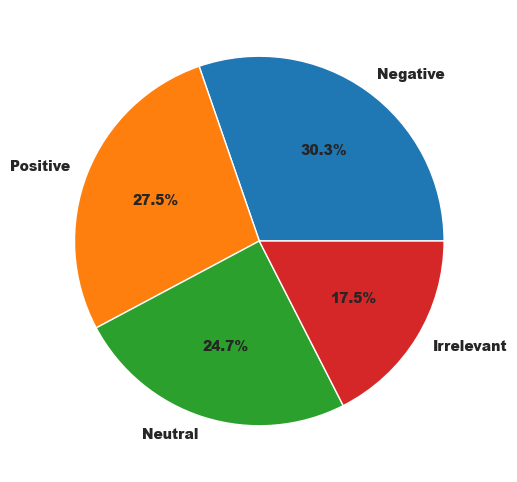

In [53]:
plt.figure(figsize=(6,6))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"})
plt.show()

In [54]:
pd.crosstab(df.Mode , df.Land).T

Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [55]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)
def text_cleaner(tx):
    
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text


In [56]:
random.seed(12)
test_text =text_cleaner( random.choice(df['Text']))
test_text = clean_emoji(test_text)
test_text

'i do not play gta any more.'

In [64]:
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.pos_}')

i => PRON
do => AUX
not => PART
play => VERB
gta => NOUN
any => PRON
more => ADV
. => PUNCT


In [65]:
doc = nlp(test_text)
for chunk in doc.ents:
    print(f'{chunk} => {chunk.label_}')


In [66]:
doc = nlp(test_text)
for chunk in doc.noun_chunks:
    print(f'{chunk} => {chunk.label_}')

i => NP
gta => NP


In [69]:
test_text

'i do not play gta any more.'

In [71]:
Tokenizer=RegexpTokenizer(r'\w+')
test_text_tokenized = Tokenizer.tokenize(test_text)
test_text_tokenized

['i', 'do', 'not', 'play', 'gta', 'any', 'more']

array([[1, 1, 1, 1, 1, 1]], dtype=int64)

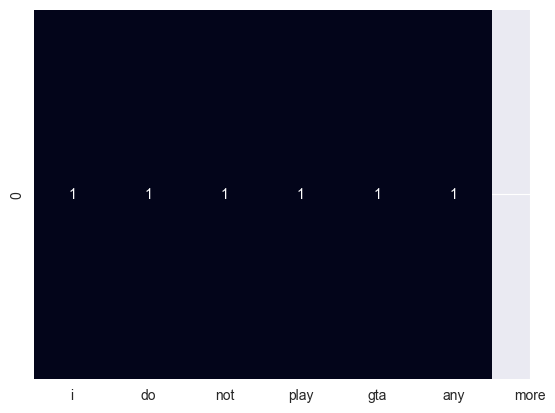

In [73]:
words  = ['i', 'do', 'not', 'play', 'gta', 'any', 'more']
counter_vectorizer = CountVectorizer()
transform = counter_vectorizer.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

array([[0.40824829, 0.40824829, 0.40824829, 0.40824829, 0.40824829,
        0.40824829]])

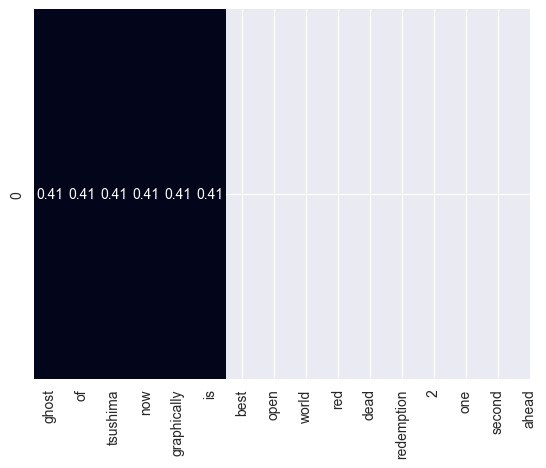

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
TF_IDF = TfidfVectorizer()
transform = TF_IDF.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

N-grams => 3-grams 

In [75]:
def n_grams(text, n):
    return [text[i:i+n] for i in range(len(text)-n+1)]
cleaned = test_text_tokenized
n_grams(cleaned, 3)


[['i', 'do', 'not'],
 ['do', 'not', 'play'],
 ['not', 'play', 'gta'],
 ['play', 'gta', 'any'],
 ['gta', 'any', 'more']]

In [78]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [80]:
stopwords_list = stopwords.words('english')
print(f'There are {len(stopwords_list) } stop words')
print('**' * 20 , '\n20 of them are as follows:\n')
for inx , value in enumerate(stopwords_list[:20]):
    print(f'{inx+1}:{value}')


There are 179 stop words
**************************************** 
20 of them are as follows:

1:i
2:me
3:my
4:myself
5:we
6:our
7:ours
8:ourselves
9:you
10:you're
11:you've
12:you'll
13:you'd
14:your
15:yours
16:yourself
17:yourselves
18:he
19:him
20:his


In [81]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

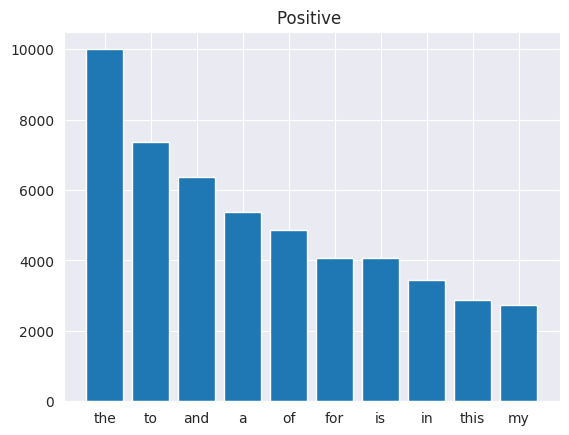

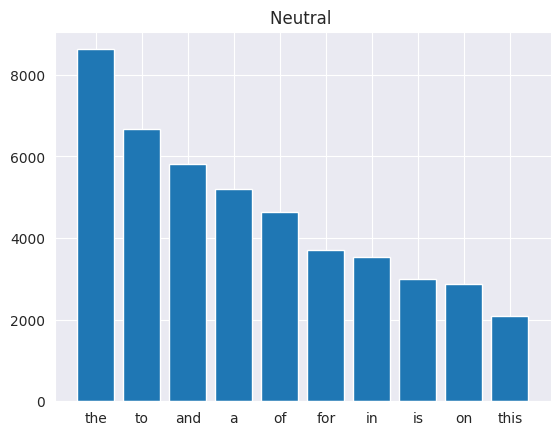

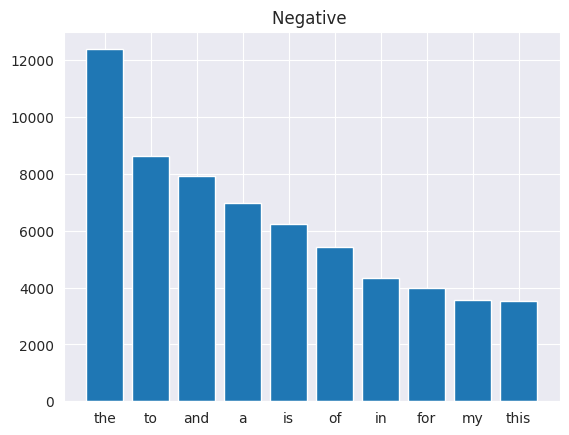

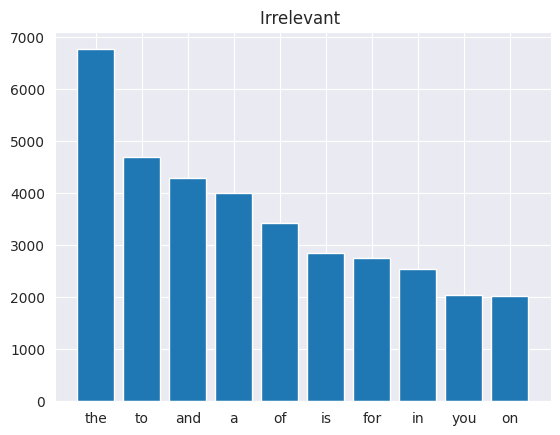

CPU times: user 5.09 s, sys: 647 ms, total: 5.74 s
Wall time: 4.66 s


In [31]:
%%time
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())



for inx , value in enumerate(sentiments):
    
    corpus = make_corpus(value)
    
    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1
    
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

In [82]:
df['Text'] = df['Text'].apply(lambda x : text_cleaner(x))
df['Text']= df['Text'].apply(lambda x : Tokenizer.tokenize(x))
df['Text'].to_frame()


,Text
0,"[i, am, coming, to, the, borders, and, i, will..."
1,"[im, getting, on, borderlands, and, i, will, k..."
2,"[im, coming, on, borderlands, and, i, will, mu..."
3,"[im, getting, on, borderlands, 2, and, i, will..."
4,"[im, getting, into, borderlands, and, i, can, ..."
...,...
74676,"[just, realized, that, the, windows, partition..."
74677,"[just, realized, that, my, mac, window, partit..."
74678,"[just, realized, the, windows, partition, of, ..."
74679,"[just, realized, between, the, windows, partit..."


Lemmas and Stems

In [83]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.lemma_}')

i => I
do => do
not => not
play => play
gta => gta
any => any
more => more
. => .


In [84]:

Stemmer = PorterStemmer()
def stopwords_cleaner(text):
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting
df['Text'] = df['Text'].apply(lambda x : stopwords_cleaner(x))

In [85]:
df['Text'][:10].to_frame()

,Text
0,come border kill
1,im get borderland kill
2,im come borderland murder
3,im get borderland 2 murder
4,im get borderland murder
5,spent hour make someth fun know huge borderlan...
6,spent coupl hour someth fun know huge borderla...
7,spent hour someth fun know huge borderland fan...
8,spent hour make someth fun know huge rhandlerr...
9,2010 spent hour make someth fun know huge rhan...


<div style="font-family:Georgia;background-color:aliceblue; padding:30px; font-size:17px ; color:#034914">

**WordCloud**<br>

word Cloud is just a data visualization technique used for representing text data in which the size of each word indicates its frequency or <br>  importance.Now , I will show the most important words(common ones) exclude stopwords for each Mode.<br>

</div>

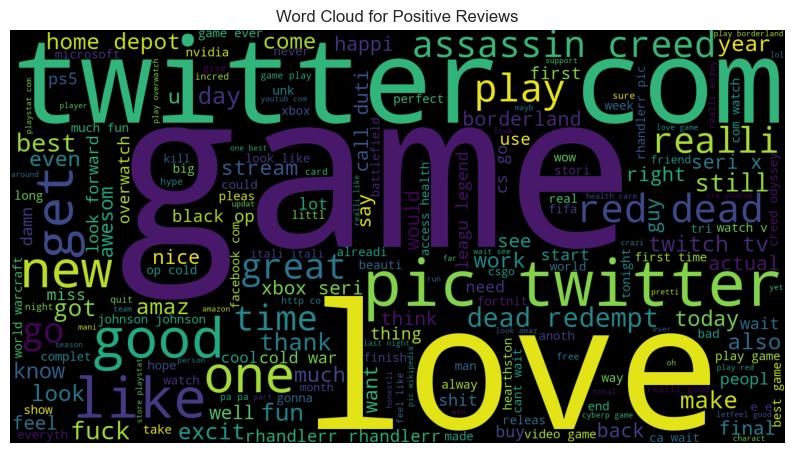

CPU times: total: 312 ms
Wall time: 1.37 s


In [86]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()


In [92]:
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())

In [93]:
len_text = [len(tx) for tx in df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')


Max Length : 797
Min Length : 0


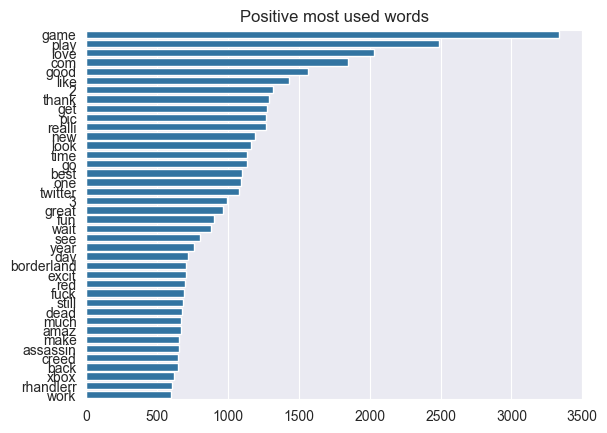

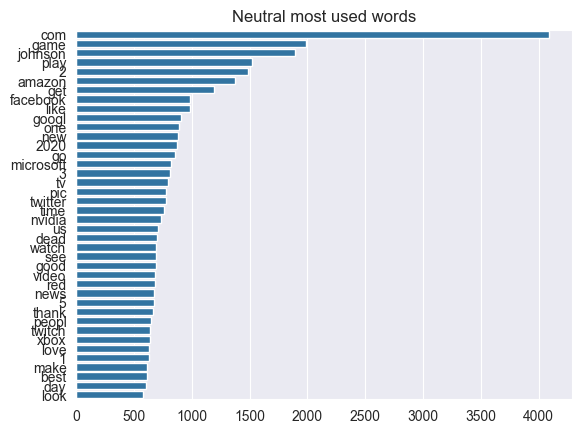

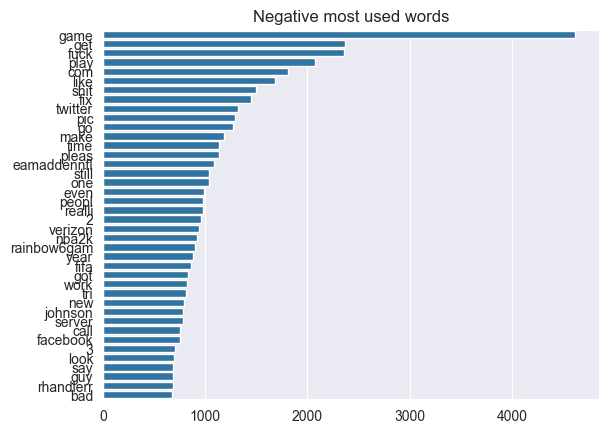

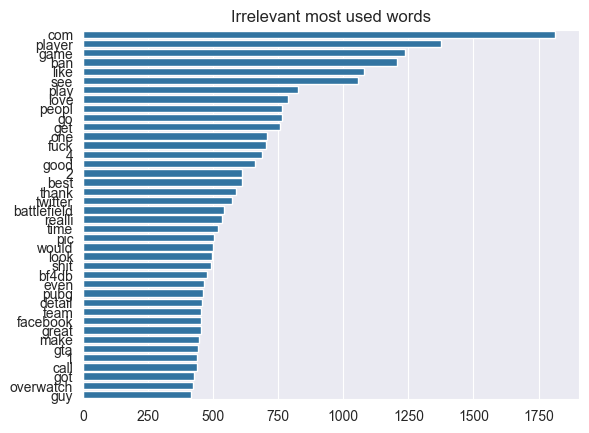

CPU times: total: 344 ms
Wall time: 785 ms


In [94]:
%%time
for inx , value in enumerate(sentiments):
    
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)
         
    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

In [95]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [96]:
df.sample(10)

,Index,Land,Mode,Text,sentiments
62234,5068,GrandTheftAuto(GTA),Positive,wanna shit,1
26798,1005,AssassinsCreed,Positive,spin seri,1
9356,12808,Xbox(Xseries),Negative,haha,0
15710,3088,Dota2,Negative,pain rhandlerr pic twitter com s6ee5hozpz,0
66492,6986,johnson&johnson,Neutral,johnson johnson su auri health payout dlvr rjt4hn,2
55098,2261,CallOfDuty,Positive,play,1
13829,8773,NBA2K,Positive,fun move jump shoot wit greeeen light,1
72228,11175,TomClancysGhostRecon,Neutral,gm fam hope great today ju want take second th...,2
65943,6893,johnson&johnson,Positive,success rest easi know covid 19 vaccin wo irri...,1
63055,7609,MaddenNFL,Negative,qb dumb wr even dumber game,0


In [97]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [98]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

In [106]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

In [99]:
class sentimentBiLSTM(nn.Module):
   
    def __init__(self, embedding_matrix, hidden_dim, output_size):

        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
     
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)

        self.fc = nn.Linear(hidden_dim*2, output_size)
        

    def forward(self, x):
 
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

In [100]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

In [101]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3


if torch.cuda.is_available():
    
       device = torch.device("cuda")
   
else:
       device = torch.device("cpu")
    

print(f'Current device is {device}')


Current device is cpu


In [102]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)


In [103]:
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[    0,     0,     0,  ...,    71,    16,   165],
         [    0,     0,     0,  ...,    63,  6867,  1133],
         [    0,     0,     0,  ...,  1808, 21856,  9621],
         ...,
         [    0,     0,     0,  ...,    24,   112,   479],
         [    0,     0,     0,  ...,    51,   307,   345],
         [    0,     0,     0,  ...,    61,   124,   227]]),
 'target': tensor([1, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 2, 2,
         0, 0, 0, 2, 1, 0, 0, 0])}

In [107]:
embedding_dict = load_vectors('glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [108]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23595, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [109]:
torch.manual_seed(12) 
torch.cuda.manual_seed(12)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 


def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

In [110]:
clip = 5
epochs = 9
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
  
    train_losses = []
    train_acc = 0.0


    model.train()
    correct = 0

 
    for data in train_loader:  

    
        inputs = data['text']
        labels = data['target']

      
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

   
        model.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, labels.long())
        loss.backward()
        train_losses.append(loss.item())
        
        accuracy = acc(output,labels)
        train_acc += accuracy
      
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    
    val_losses = []
    val_acc = 0.0

    model.eval()
    for data in valid_loader:

        
        inputs = data['text']
        labels = data['target']

        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)


        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
       
        val_loss = criterion(output, labels.long())
     
        val_losses.append(val_loss.item())


        accuracy = acc(output,labels)
        val_acc += accuracy
        epoch_train_loss = np.mean(train_losses)


    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        valid_loss_min = epoch_val_loss
    print(30 * '==' , '>')

Epoch 1
train_loss : 0.8611265863538919 val_loss : 0.7704098333315028
train_accuracy : 59.378270881306264 val_accuracy : 64.8942851161817
Validation loss decreased (inf --> 0.7704098333315028)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.6694981677614731 val_loss : 0.6522121162755911
train_accuracy : 70.75919335705812 val_accuracy : 71.36975786755984
Validation loss decreased (0.7704098333315028 --> 0.6522121162755911)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.5171076726357675 val_loss : 0.5598170546943976
train_accuracy : 78.6773428232503 val_accuracy : 76.24031819133347
Validation loss decreased (0.6522121162755911 --> 0.5598170546943976)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.4111652517871175 val_loss : 0.5105002043764597
train_accuracy : 83.57755913753402 val_accuracy : 79.24080664294188
Validation 

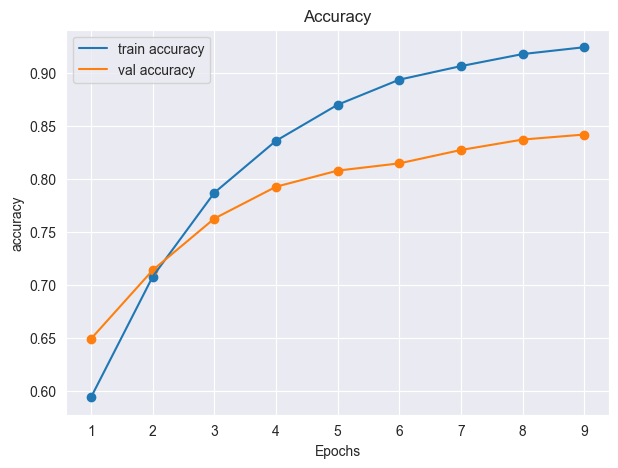

In [111]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

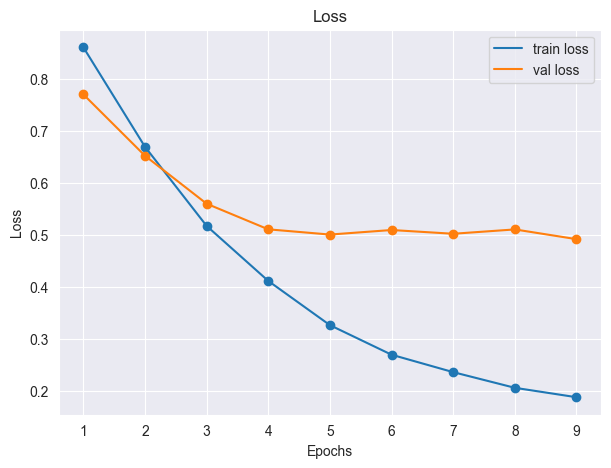

In [112]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()